# Waste Management Image Classification using Inception V3 headless model

## Importing Libraries

In [ ]:
import numpy as np
import time
import os
import shutil

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
from keras import layers
from keras.layers import Dense, Dropout, Flatten
import tf_keras
import datetime
import random
import time

%load_ext tensorboard

2024-10-23 13:38:06.000760: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-23 13:38:06.002971: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-23 13:38:06.029896: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-23 13:38:06.030621: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-23 13:38:16.837161: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [ ]:
directories_in_curdir = list(filter(os.path.isdir, os.listdir(os.curdir)))
print(directories_in_curdir)

['solidwasteclassification', 'AsolidwasteClassification', 'share', 'logs', 'etc', '.ipynb_checkpoints', 'screenshots', 'bin', 'lib']


In [ ]:
print(os.getcwd())

/home/sdp950/dl_task1


## Data Acqusition

In [ ]:
import os

# folder path
dir_path = r'/home/sdp950/dl_task1/AsolidwasteClassification'

# list file and directories
data_dir = os.listdir(dir_path)
print(data_dir)

['glassbottles', 'plasticbottles', 'nonrecyclable', 'tincans']


In [ ]:
No_of_files_dir = sum([len(files) for r, d, files in os.walk("/home/sdp950/dl_task1/AsolidwasteClassification")])
print(f"No.of files in the directory is:", No_of_files_dir)

No.of files in the directory is: 2387


# Implementation 2: Using pre-trained model Inception V3

In [ ]:
mobilenet_v2 ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"

classifier_model2 = inception_v3 #@param ["mobilenet_v2", "inception_v3"] {type:"raw"}

## Image reshaping

In [ ]:
IMAGE_SHAPE = (224, 224)

classifier2 = tf_keras.Sequential([
    hub.KerasLayer(classifier_model2, input_shape=IMAGE_SHAPE+(3,))
])

2024-10-23 13:38:54.583257: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-23 13:38:54.588685: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [ ]:
labels_path1 = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels1 = np.array(open(labels_path1).read().splitlines())

## Assigning Batch and Image size

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
img_height = 224
img_width = 224

## Splitting the train, validation and test dataset

In [ ]:
train_dataset_Inception = tf.keras.utils.image_dataset_from_directory(
  dir_path,
  shuffle = True,
  validation_split=0.3,
  subset="training",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

Found 2387 files belonging to 4 classes.
Using 1671 files for training.


In [ ]:
validation_dataset_Inception = tf.keras.utils.image_dataset_from_directory(
  dir_path,
  shuffle=True,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

Found 2387 files belonging to 4 classes.
Using 477 files for validation.


In [ ]:
val_batches1 = tf.data.experimental.cardinality(validation_dataset_Inception)
test_dataset1 = validation_dataset_Inception.take(val_batches1 // 5)
validation_dataset1 = validation_dataset_Inception.skip(val_batches1 // 5)

In [ ]:
from collections import Counter

all_image_paths = []
for class_name in train_dataset_Inception.class_names:
  all_image_paths.extend(
      [os.path.join(dir_path, class_name, fname) for fname in os.listdir(os.path.join(dir_path, class_name))]
  )

  #extract the class labels from the file paths
  labels = [ os.path.basename(os.path.dirname(path)) for path in all_image_paths]

  #counting the number pf samples in each class
  sample_count = Counter(labels)

Labels: dict_keys(['glassbottles', 'nonrecyclable', 'plasticbottles', 'tincans'])
Value count is: dict_values([759, 383, 709, 536])


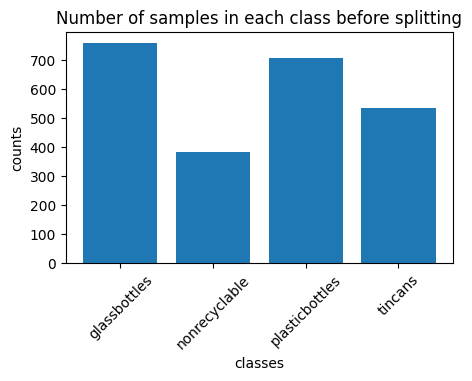

In [ ]:
print("Labels:", sample_count.keys())
print("Value count is:", sample_count.values())
x = sample_count.keys()
y = sample_count.values()
plt.figure(figsize = (5,3))
plt.bar(x,y)
plt.title("Number of samples in each class before splitting")
plt.xlabel('classes')
plt.ylabel('counts')
plt.xticks(rotation=45)
plt.show()

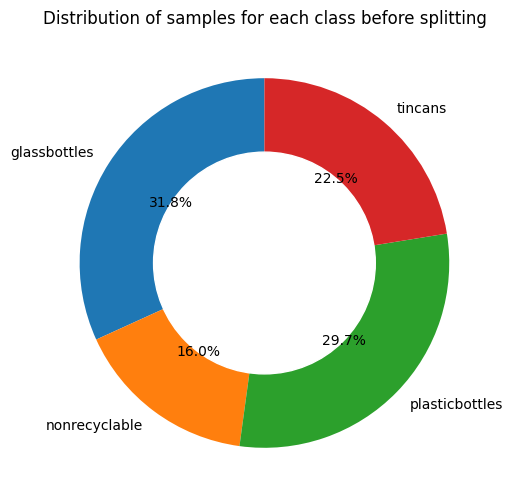

In [ ]:
plt.figure(figsize = (8,6))
plt.pie(sample_count.values(), labels=sample_count.keys(), autopct = '%1.1f%%', startangle=90)

my_circle=plt.Circle( (0,0), 0.6, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)

plt.title("Distribution of samples for each class before splitting")
plt.show()

# Data Augmentation

In [ ]:
data_augumentation = tf_keras.Sequential([
    tf_keras.layers.RandomFlip('horizontal'),
    tf_keras.layers.RandomFlip('vertical'), #Randomly adjust the brightness by 10%
    tf_keras.layers.RandomRotation(0.2), #Randomly rotate by 20%
    tf_keras.layers.RandomZoom(0.2), #Randomly zoom by 20%
    tf_keras.layers.RandomContrast(0.1), #Randomly adjust the contrast by 10%
    tf_keras.layers.RandomBrightness(0.1), #Randomly adjust the brightness by 10%
])

In [ ]:
def augument_image(image, label):
  return data_augumentation(image),label

#Apply data augumentation
augumented_train_dataset = train_dataset_Inception.map(augument_image)

In [ ]:
# Create a function to upsample the dataset to 1500 image per class
import random

def upsample(dataset, target_count = 1200):
  images_per_class = {}
  for image,label in dataset.unbatch():
    label_value = label.numpy()
    if label_value not in images_per_class:
      images_per_class[label_value] = []
    images_per_class[label_value].append((image,label))

  balanced_images,balanced_labels =[], []

  for label_value,images in images_per_class.items():
    count = len(images)
    if count < target_count:
      needed = target_count - count
      sampled_images = random.choices(images, k=needed)
      balanced_images.extend([img for img,lbl in sampled_images])
      balanced_labels.extend([lbl for img,lbl in sampled_images])

    balanced_images.extend([img for img,lbl in images])
    balanced_labels.extend([lbl for img,lbl in images])

  balanced_images = np.array(balanced_images)
  balanced_labels = np.array(balanced_labels)

  return tf.data.Dataset.from_tensor_slices((balanced_images, balanced_labels)).batch(BATCH_SIZE)


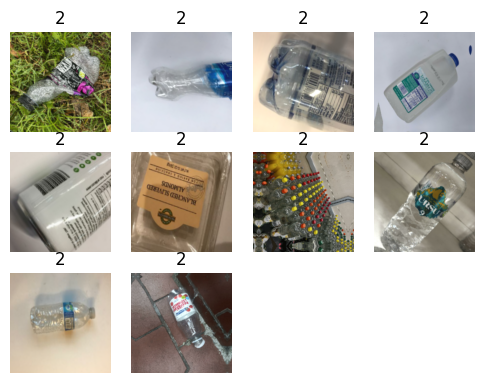

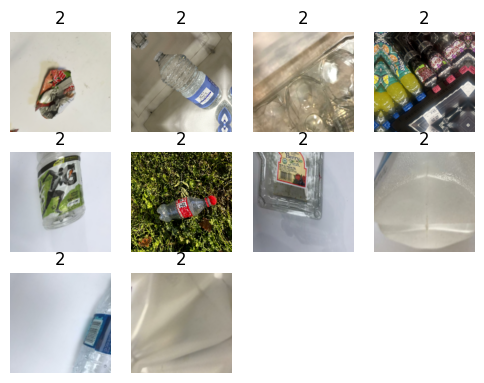

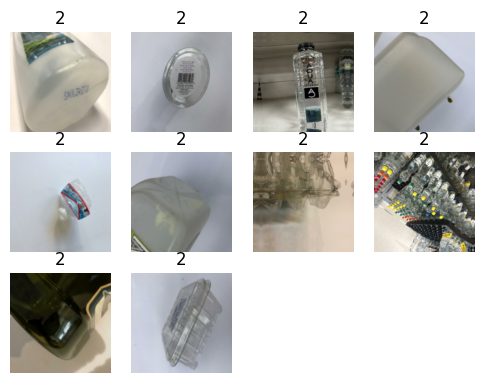

In [ ]:
#UPSAMPLING

import matplotlib.pyplot as plt

upsampled_train_dataset = upsample(augumented_train_dataset, target_count = 1200)

for images,labels in upsampled_train_dataset.take(3):
  plt.figure(figsize=(6,6))
  for i in range(10):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(int(labels[i]))
    plt.axis("off")

In [ ]:
sample_count = 0

In [ ]:
class_names = np.array(train_dataset_Inception.class_names)
print(class_names)

['glassbottles' 'nonrecyclable' 'plasticbottles' 'tincans']


## Normalizing the layer (Rescaling)

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_dataset_Inception.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = validation_dataset1.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
test_ds = test_dataset1.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


2024-10-23 13:39:59.168520: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [ ]:
result_batch = classifier2.predict(train_ds)

53/53 [==============================] - 28s 377ms/step


In [ ]:
predicted_class_names = imagenet_labels1[tf.math.argmax(result_batch, axis=-1)]
predicted_class_names

array(['wine bottle', 'beer bottle', 'lotion', ..., 'nipple',
       'beer bottle', 'lotion'], dtype='<U30')

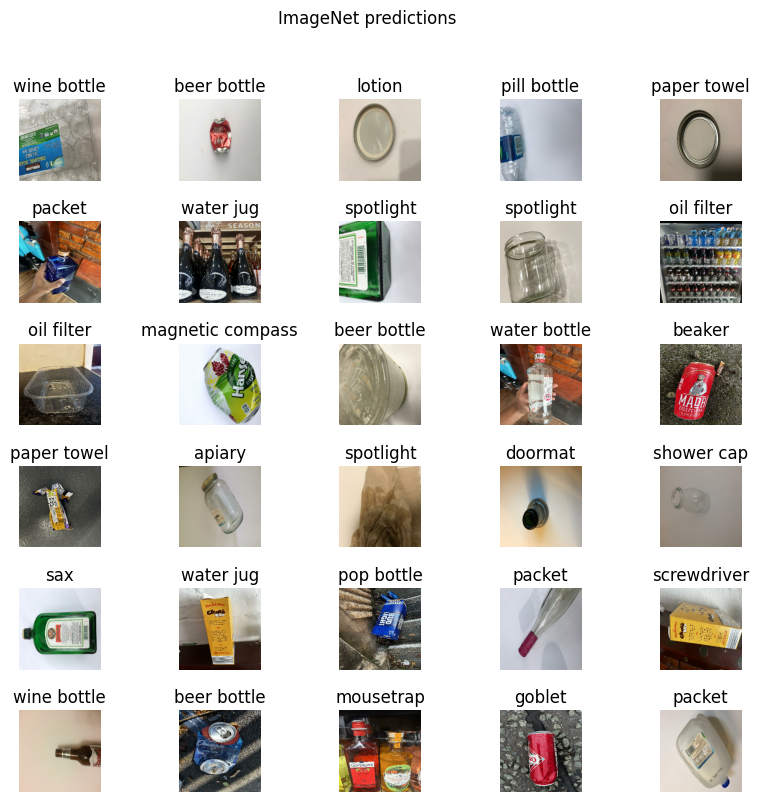

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

# Download the headless model

In [ ]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

feature_extractor_model2 = inception_v3 #@param ["mobilenet_v2", "inception_v3"] {type:"raw"}

In [ ]:
start = time.perf_counter()

In [ ]:
feature_extractor_layer2 = hub.KerasLayer(
    feature_extractor_model2,
    input_shape=(224, 224, 3),
    trainable=False)

In [ ]:
feature_batch = feature_extractor_layer2(image_batch)
print(feature_batch.shape)

(32, 2048)


In [ ]:
num_classes = len(class_names)
print(num_classes)

4


## Model training

In [ ]:
num_classes = len(class_names)

model2 = tf_keras.Sequential([
  feature_extractor_layer2,
  tf_keras.layers.Dense(num_classes),
  tf_keras.layers.Flatten(),
  tf_keras.layers.Dropout(0.3)
])

In [ ]:
predictions = model2(image_batch)

In [ ]:
predictions.shape

TensorShape([32, 4])

In [ ]:
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 module_wrapper_3 (ModuleWr  (32, 2048)                21802784  
 apper)                                                          
                                                                 
 dense_2 (Dense)             (32, 4)                   8196      
                                                                 
 flatten_2 (Flatten)         (32, 4)                   0         
                                                                 
 dropout_2 (Dropout)         (32, 4)                   0         
                                                                 
Total params: 21810980 (83.20 MB)
Trainable params: 8196 (32.02 KB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [ ]:
model2.compile(
  optimizer=tf_keras.optimizers.Adam(learning_rate=0.001),
  loss=tf_keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [ ]:
log_dir2 = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf_keras.callbacks.TensorBoard(
    log_dir=log_dir2,
    histogram_freq=1) # Enable histogram computation for every epoch.

In [ ]:
from keras import callbacks
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

In [ ]:
NUM_EPOCHS = 20
history2 = model2.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=tensorboard_callback)

Layer ModuleWrapper was created by passing
non-serializable argument values in `__init__()`,
and therefore the layer must override `get_config()` in
order to be serializable. Please implement `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2, **kwargs):
        super().__init__(**kwargs)
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config


Layer ModuleWrapper was created by passing
non-serializable argument values in `__init__()`,
and therefore the layer must override `get_config()` in
order to be serializable. Please implement `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2, **kwargs):
        super().__init__(**kwargs)
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config


Epoch 1/20
53/53 [==============================] - 28s 457ms/step - loss: 1.1376 - acc: 0.5165 - val_loss: 0.6535 - val_acc: 0.7428
Epoch 2/20
53/53 [==============================] - 25s 480ms/step - loss: 0.7389 - acc: 0.6822 - val_loss: 0.6827 - val_acc: 0.7270
Epoch 3/20
53/53 [==============================] - 27s 521ms/step - loss: 0.6874 - acc: 0.7092 - val_loss: 0.6543 - val_acc: 0.7297
Epoch 4/20
53/53 [==============================] - 23s 440ms/step - loss: 0.6002 - acc: 0.7391 - val_loss: 0.5500 - val_acc: 0.7953
Epoch 5/20
53/53 [==============================] - 28s 535ms/step - loss: 0.5672 - acc: 0.7546 - val_loss: 0.5848 - val_acc: 0.7690
Epoch 6/20
53/53 [==============================] - 24s 446ms/step - loss: 0.5180 - acc: 0.7846 - val_loss: 0.5613 - val_acc: 0.7769
Epoch 7/20
53/53 [==============================] - 24s 446ms/step - loss: 0.5075 - acc: 0.7792 - val_loss: 0.5971 - val_acc: 0.7480
Epoch 8/20
53/53 [==============================] - 24s 450ms/step - 

In [ ]:
elapsed_time1 = time.perf_counter() - start

In [ ]:
print("Elapsed time for Inception V3 is %.2f seconds." %elapsed_time1)
print("Elapsed time for Inception V3 is %.2f minutes." %(elapsed_time1/60))

Elapsed time for Inception V3 is 464.80 seconds.
Elapsed time for Inception V3 is 7.75 minutes.


In [ ]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 9728), started 0:56:26 ago. (Use '!kill 9728' to kill it.)

## Model Evaluation

Text(0.5, 1.0, 'Training and Validation Accuracy')

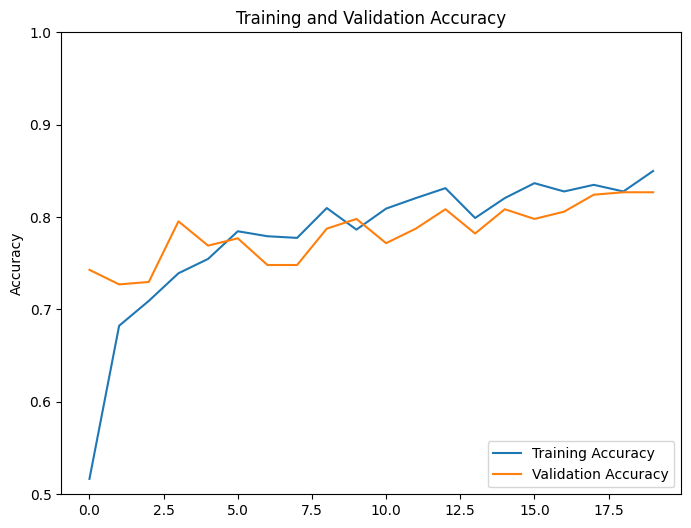

In [ ]:
acc = history2.history['acc']
val_acc = history2.history['val_acc']

plt.figure(figsize=(8, 6))
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

Text(0.5, 0, 'epoch')

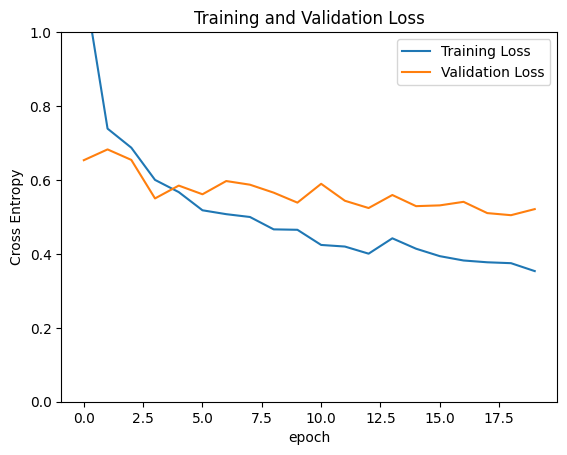

In [ ]:
loss = history2.history['loss']
val_loss = history2.history['val_loss']

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

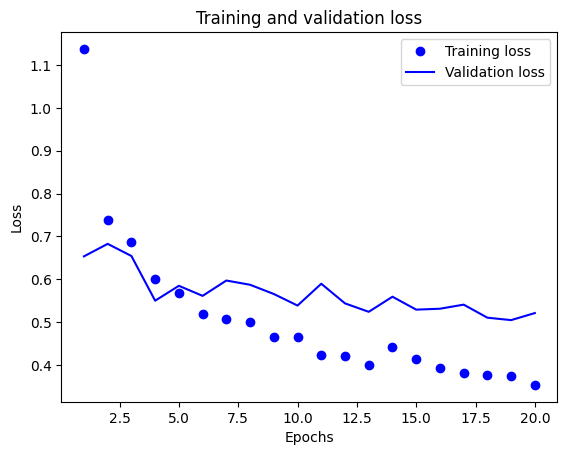

In [ ]:
acc1 = history2.history['acc']
val_acc1 = history2.history['acc']
loss1 = history2.history['loss']
val_loss1 = history2.history['val_loss']
epochs1 = range(1, len(acc1) + 1)

plt.plot(epochs1, loss1, 'bo', label='Training loss')
plt.plot(epochs1, val_loss1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
#plt.clf()

range(1, 21)


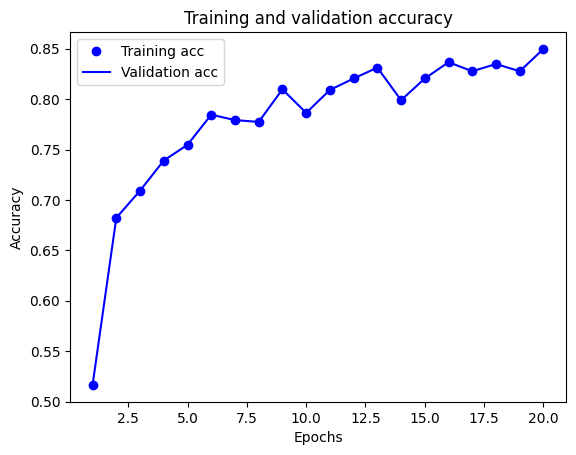

In [ ]:
print(epochs1)
plt.plot(epochs1, acc1, 'bo', label='Training acc')
plt.plot(epochs1, val_acc1, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
predicted_batch = model2.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

1/1 [==============================] - 1s 674ms/step
['plasticbottles' 'tincans' 'tincans' 'plasticbottles' 'tincans'
 'glassbottles' 'glassbottles' 'glassbottles' 'glassbottles'
 'plasticbottles' 'nonrecyclable' 'tincans' 'glassbottles'
 'plasticbottles' 'tincans' 'nonrecyclable' 'plasticbottles'
 'nonrecyclable' 'glassbottles' 'glassbottles' 'glassbottles'
 'nonrecyclable' 'nonrecyclable' 'glassbottles' 'nonrecyclable'
 'glassbottles' 'tincans' 'glassbottles' 'tincans' 'plasticbottles'
 'tincans' 'plasticbottles']


## Model Predictions

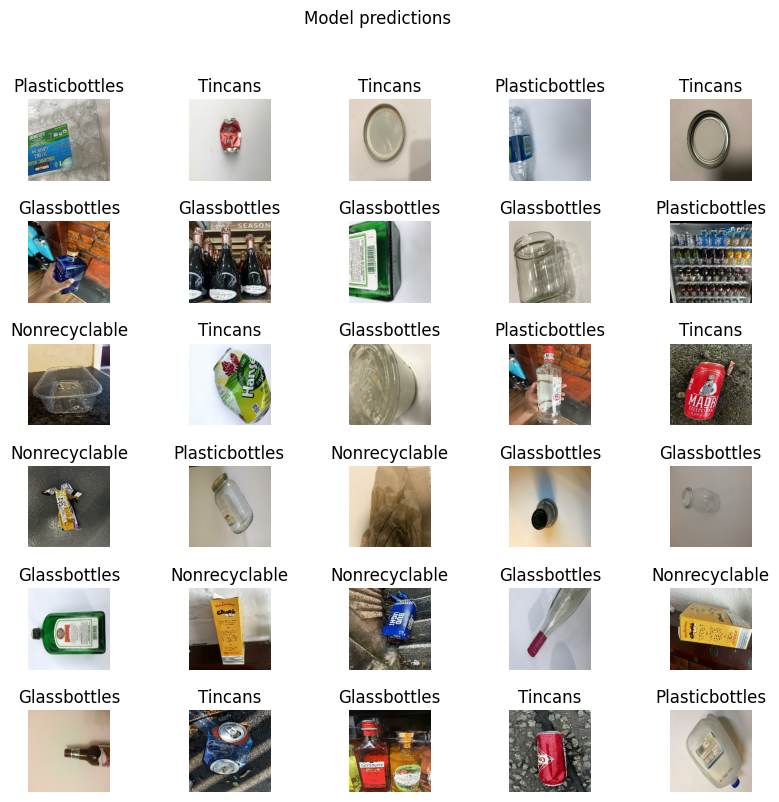

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions")

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report, precision_score

In [ ]:
accuracy, loss = model2.evaluate(test_ds)

3/3 [==============================] - 1s 300ms/step - loss: 0.5614 - acc: 0.8021


In [ ]:
y_true = np.array(val_ds)

In [ ]:
predictions = model2.predict(val_ds)
y_pred = np.argmax(predictions, axis=-1)

y_true = np.concatenate([y for x, y in val_ds], axis=-1)

12/12 [==============================] - 4s 303ms/step


## Evaluation metrics

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.86      0.86       122
           1       0.85      0.76      0.80        54
           2       0.82      0.81      0.82       124
           3       0.76      0.84      0.80        81

    accuracy                           0.83       381
   macro avg       0.83      0.82      0.82       381
weighted avg       0.83      0.83      0.83       381



In [ ]:
print("Accuracy for Inception V3 model is:", accuracy_score(y_true, y_pred))
print("Precision for Inception V3 model is:", precision_score(y_true, y_pred, average='weighted'))
print("Recall for Inception V3 model is:", recall_score(y_true, y_pred, average='weighted'))
print("f1 score for Inception V3 model is:", f1_score(y_true, y_pred, average='weighted'))
print("Precision score for MobileNet V2 model is:", precision_score(y_true, y_pred, average='weighted'))

Accuracy for Inception V3 model is: 0.8267716535433071
Precision for Inception V3 model is: 0.8286129849235214
Recall for Inception V3 model is: 0.8267716535433071
f1 score for Inception V3 model is: 0.8269101584092009
Precision score for MobileNet V2 model is: 0.8286129849235214


## Confusion matrix

[[105   0  10   7]
 [  1  41   4   8]
 [ 12   5 101   6]
 [  3   2   8  68]]


Text(0.5, 1.0, 'Confusion Matric Inception V3 virtual environment')

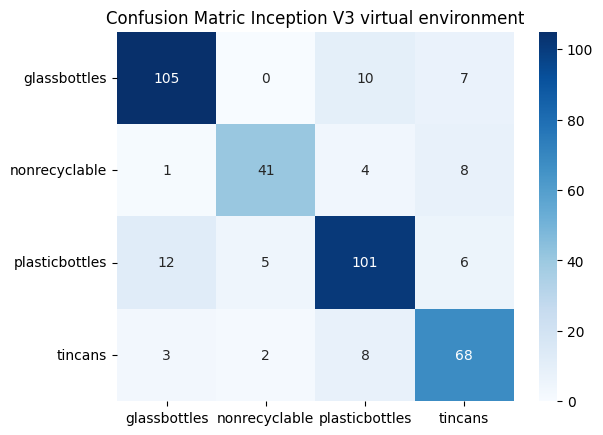

In [ ]:
import seaborn as sns

conf_mat = confusion_matrix(y_true, y_pred)
print(conf_mat)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matric Inception V3 virtual environment')

In [ ]:
import pandas as pd
column_name = ['glassbottles', 'nonrecyclable', 'plasticbottles', 'tincans']
df = pd.DataFrame(conf_mat, columns=column_name)
df

,glassbottles,nonrecyclable,plasticbottles,tincans
0,105,0,10,7
1,1,41,4,8
2,12,5,101,6
3,3,2,8,68


In [ ]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,glassbottles,nonrecyclable,plasticbottles,tincans
glassbottles,1.000000,-0.460620,-0.203123,-0.365151
nonrecyclable,-0.460620,1.000000,-0.289161,-0.322544
plasticbottles,-0.203123,-0.289161,1.000000,-0.345865
tincans,-0.365151,-0.322544,-0.345865,1.000000


## Heatmap visualization

[None, None, None, None, None, None, None, None]

<Figure size 400x300 with 0 Axes>

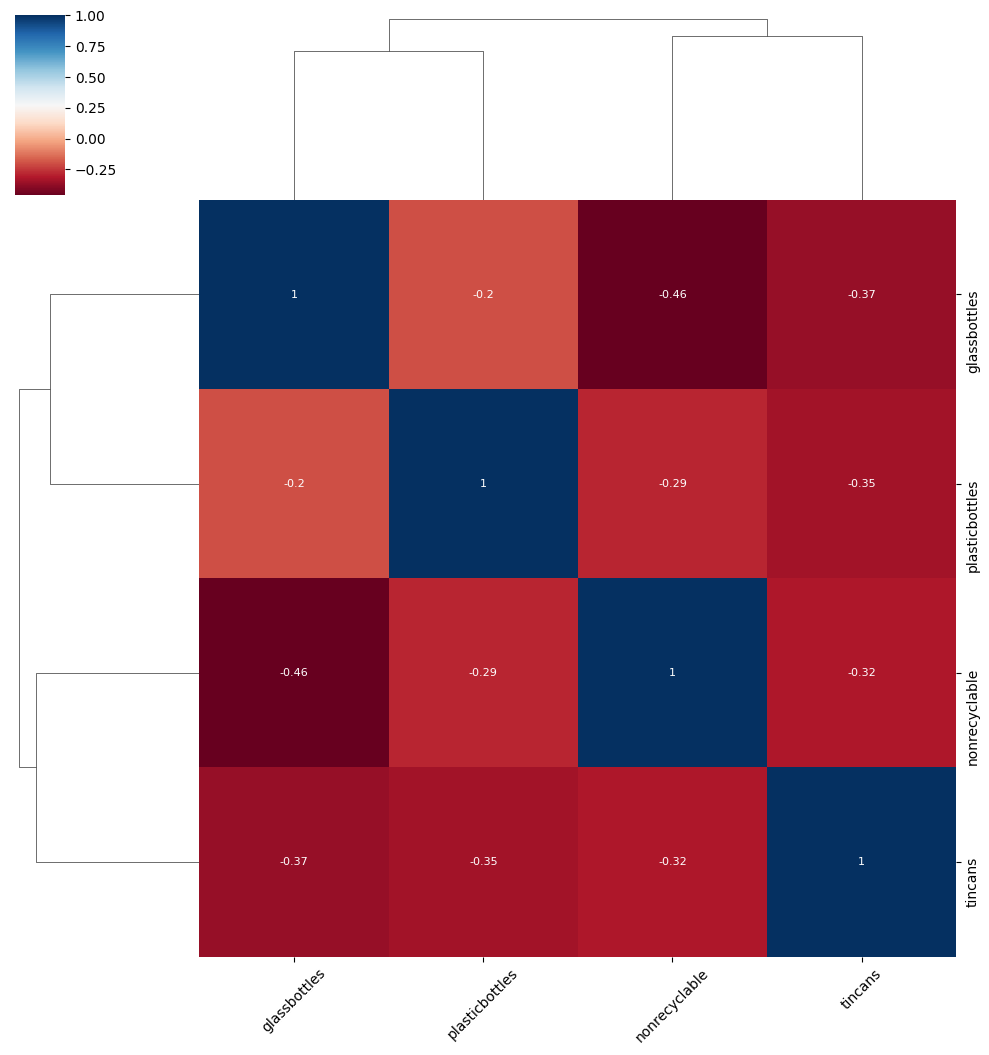

In [ ]:
plt.figure(figsize=(4,3))
g = sns.clustermap(df.corr(),
                   method = 'complete',
                   cmap   = 'RdBu',
                   annot  = True,
                   annot_kws = {'size': 8})
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=45)

## Correlation heatmap

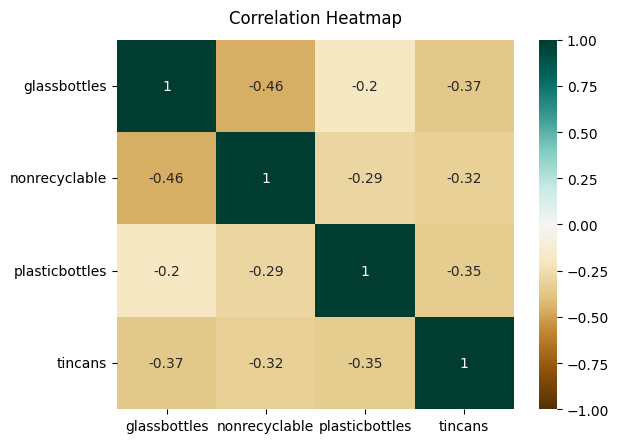

<Figure size 400x300 with 0 Axes>

In [ ]:
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);
plt.figure(figsize=(4,3))
plt.show()